# Florence-2: Open Source Vision Foundation Model

Florence-2 is a lightweight vision-language foundation model developed by Microsoft Azure AI and open-sourced under the MIT license. It aims to achieve a unified, prompt-based representation for diverse vision and vision-language tasks, including captioning, object detection, grounding, and segmentation. Despite its compact size, Florence-2 rivals much larger models like [Kosmos-2](../kosmos2-multimodal-large-language-model/kosmos2-multimodal-large-language-model.ipynb) in performance. Florence-2 represents a significant advancement in vision-language models by combining lightweight architecture with robust capabilities, making it highly accessible and versatile. Its unified representation approach, supported by the extensive FLD-5B dataset, enables it to excel in multiple vision tasks without the need for separate models. This efficiency makes Florence-2 a strong contender for real-world applications, particularly on devices with limited resources. 

More details about model can be found in [model's resources collection](https://huggingface.co/collections/microsoft/florence-6669f44df0d87d9c3bfb76de) and original [paper](https://arxiv.org/abs/2311.06242)

In this tutorial we consider how to convert and run Florence2 using OpenVINO.

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Select model](#Select-model)
- [Convert model](#Convert-model)
- [Select inference device](#Select-inference-device)
- [Run model inference](#Run-model-inference)
- [Interactive Demo](#Interactive-Demo)

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/florence2/florence2.ipynb" />

### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import platform

%pip install -q "openvino>=2024.3.0" "einops" "torch>2.1" "torchvision" "timm>=0.9.8" "transformers>=4.41" "pillow" "gradio>=4.19" --extra-index-url https://download.pytorch.org/whl/cpu

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

In [2]:
import requests
from pathlib import Path

if not Path("ov_florence2_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/florence2/ov_florence2_helper.py")
    open("ov_florence2_helper.py", "w").write(r.text)


if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/florence2/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w").write(r.text)

## Select model
[back to top ⬆️](#Table-of-contents:)

The Florence-2 series consists of two models: Florence-2-base and Florence-2-large, with 0.23 billion and 0.77 billion parameters, respectively. Additionally, authors provide finetuned on collection of downstream tasks model versions. In this tutorial you can select one of available model. By default, we will use [Florence-2-base-ft](https://huggingface.co/microsoft/Florence-2-base-ft).

In [ ]:
from ov_florence2_helper import convert_florence2, get_model_selector

model_selector = get_model_selector()

model_selector

## Convert model
[back to top ⬆️](#Table-of-contents:)

Florence2 is PyTorch model. OpenVINO supports PyTorch models via conversion to OpenVINO Intermediate Representation (IR). [OpenVINO model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html#convert-a-model-with-python-convert-model) should be used for these purposes. `ov.convert_model` function accepts original PyTorch model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. Converted model can be used for saving on disk using `ov.save_model` function or directly loading on device using `core.complie_model`. 
`ov_florence2_helper.py` script contains helper function for model conversion, please check its content if you interested in conversion details.

<details>
  <summary><b>Click here for more detailed explanation of conversion steps</b></summary>
The model takes images and task prompts as input, generating the desired results in text format. It uses a DaViT vision encoder to convert images into visual token embeddings. These are then concatenated with BERT-generated text embeddings and processed by a transformer-based multi-modal encoder-decoder to generate the response.

![](https://blog.roboflow.com/content/images/2024/06/Screenshot-2024-06-19-at-22.34.35-1-Medium.jpeg)    
    
To sum up above, model consists of 4 parts:

* **Image Encoder** for transforming input images into flattened visual token embeddings. 
* **Input Embedding** for conversion input text tokens or task description into embedding space.
* **Encoder** and **Decoder** for generation answer based on input embeddings provided by Image Encoder and Input Embedding models. The model employs a seq2seq framework, seamlessly integrating the image encoder with a multi-modality encoder-decoder.
    
We will convert each part separately, then combine them in inference pipeline.

</details>


In [4]:
model_id = model_selector.value
model_path = Path(model_id.split("/")[-1])

# Uncomment the line to see conversion code
# ??convert_florence2

For reducing memory consumption, weights compression optimization can be applied using [NNCF](https://github.com/openvinotoolkit/nncf). Weight compression aims to reduce the memory footprint of a model. It can also lead to significant performance improvement for large memory-bound models, such as Large Language Models (LLMs). LLMs and other models, which require extensive memory to store the weights during inference, can benefit from weight compression in the following ways:

* enabling the inference of exceptionally large models that cannot be accommodated in the memory of the device;

* improving the inference performance of the models by reducing the latency of the memory access when computing the operations with weights, for example, Linear layers.

[Neural Network Compression Framework (NNCF)](https://github.com/openvinotoolkit/nncf) provides 4-bit / 8-bit mixed weight quantization as a compression method primarily designed to optimize LLMs. The main difference between weights compression and full model quantization (post-training quantization) is that activations remain floating-point in the case of weights compression which leads to a better accuracy. In addition, weight compression is data-free and does not require a calibration dataset, making it easy to use.

`nncf.compress_weights` function can be used for performing weights compression. The function accepts an OpenVINO model and other compression parameters. Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

More details about weights compression, can be found in [OpenVINO documentation](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html).

Please select below whether you would like to run INT4 weight compression.

In [ ]:
from ov_florence2_helper import compression_widget

to_compress_weights = compression_widget()

to_compress_weights

In [ ]:
convert_florence2(model_id, model_path, to_compress_weights.value)

## Select inference device
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from notebook_utils import device_widget

device = device_widget()

device

## Run model inference
[back to top ⬆️](#Table-of-contents:)

`OvFlorence2Model` class defined in `ov_florence2_helper.py` provides convenient way for running model. It accepts directory with converted model and inference device as arguments. For running model we will use `generate` method.

In [8]:
from ov_florence2_helper import OVFlorence2Model

# Uncomment the line to see model class code
# ??OVFlorence2Model

In [9]:
model = OVFlorence2Model(model_path, device.value)

Additionally, for model usage we also need `Processor` class, that distributed with original model and can be loaded using `AutoProcessor` from `transformers` library. Processor is responsible for input data preparation and decoding model output.

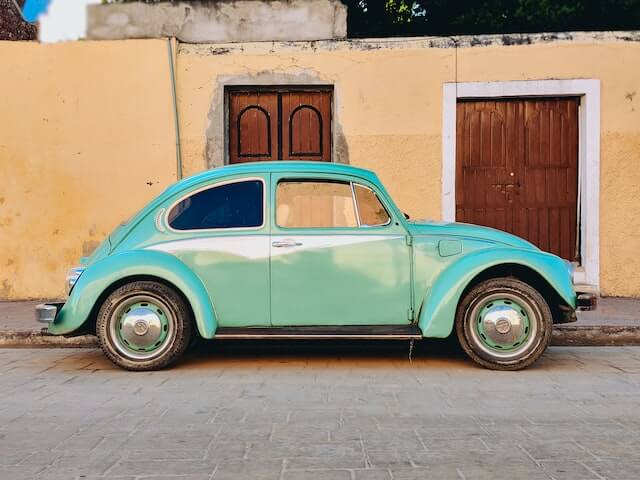

In [10]:
import requests
from PIL import Image

from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True)

prompt = "<OD>"

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

image

Let's check model capabilities in Object Detection.

In [11]:
inputs = processor(text=prompt, images=image, return_tensors="pt")

generated_ids = model.generate(input_ids=inputs["input_ids"], pixel_values=inputs["pixel_values"], max_new_tokens=1024, do_sample=False, num_beams=3)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

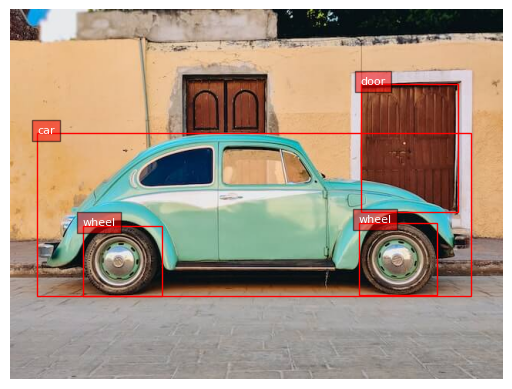

In [12]:
from gradio_helper import plot_bbox

fig = plot_bbox(image, parsed_answer["<OD>"])

 More model capabilities will be demonstrated in interactive demo.

## Interactive Demo
[back to top ⬆️](#Table-of-contents:)

In this section, you can see model in action on various of supported vision tasks. Please provide input image or select one from examples and specify task (Please note, that some of them may additionally requires to provide text input, e.g. description for region for segmentation or phrase for grounding).

<details>
  <summary><b>Click here for more detailed info about supported tasks</b></summary>
    Florence-2 is designed to handle a variety of vision and vision-language tasks through its unified, prompt-based representation. The key vision tasks performed by Florence-2 include:
    <ul>
        <li><b>Caption</b>: Generating brief textual descriptions of images, capturing the essence of the scene.</li>
        <li><b>Detailed Caption</b>: Producing more elaborate textual descriptions, providing richer information about the image.</li>
        <li><b>More Detailed Caption</b>: Creating comprehensive textual descriptions that include extensive details about the image.</li>
        <li><b>Region Proposal</b>: Identifying regions of interest within an image to focus on specific areas.</li>
        <li><b>Object Detection</b>: Locating and identifying objects within an image, providing bounding boxes and labels for each detected object.</li>
        <li><b>Dense Region Caption</b>: Generating textual descriptions for densely packed regions within an image.</li>
        <li><b>Phrase Grounding</b>: Associating phrases in a text description with specific regions in an image, linking textual descriptions to visual elements.</li>
        <li><b>Referring Expression Segmentation</b>: Identifying regions in an image that correspond to natural language expressions, making it adept at tasks that require fine-grained visual-textual alignment.Segmenting regions in an image based on referring expressions, providing detailed object boundaries.</li>
        <li><b>Open Vocabulary Detection</b>: Detecting objects in an image using a flexible and extensive vocabulary.</li>
        <li><b>Region to Text</b>: Converting regions of an image into corresponding textual descriptions.</li>
        <li><b>Text Detection and Recognition</b>: Detecting and recognizing text within an image, providing both text and region information.</li>
     </ul>

</details>


In [ ]:
from gradio_helper import make_demo

demo = make_demo(model, processor)

try:
    demo.launch(debug=True, height=600)
except Exception:
    demo.launch(debug=True, share=True, height=600)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/